# Hybrid of Resampling and Cost Sensitive of Random Forest

This notebook is for testing the imbalanced-learning of various RandomForestClassifiers

## 1) Vanilla

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
dfs = pd.read_csv('./processed.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape, test.shape

((75000, 23), (25000, 23))

In [3]:
le = LabelEncoder()
dfs['Month'] = le.fit_transform(dfs['Month'])
train['Month'] = le.transform(train['Month'])
test['Month'] = le.transform(test['Month'])

In [4]:
target = 'Credit_Score'
cat_col = ['Customer_ID', 'Month', 'Credit_Mix', 'Credit_History_Age',
           'Payment_of_Min_Amount', 'Payment_Behaviour']
cat_dims = {}
for col in cat_col:
    cat_dims[col] = len(list(dfs[col].unique()))
    print(col, ': ', cat_dims[col])
cat_col_idx = [list(dfs.columns).index(col) for col in cat_col]
cat_col_dims = [cat_dims[col] for col in cat_col]
all_col_list = [col for col in dfs.columns if col !=target]

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Payment_of_Min_Amount :  3
Payment_Behaviour :  6


In [5]:
x_train = train.loc[:, all_col_list].values
y_train = train.loc[:, target].values
x_test = test.loc[:, all_col_list].values
y_test = test.loc[:, target].values

In [6]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def roc_curve_plot(x_test, y_test, model):

    y_test = pd.get_dummies(y_test).values
    # make sample data
    n_classes = 3

    clf = model
    y_score = clf.predict_proba(x_test)

    # ROC & AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    class_name = ['Poor','Standard','Good']
    plt.figure(figsize=(15, 5))
    for idx, i in enumerate(range(n_classes)):
        plt.subplot(131+idx)
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Class :{class_name[idx]}')
        plt.legend(loc="lower right")
    plt.show()

    print("roc_auc_score: ", roc_auc_score(y_test, y_score, multi_class='raise'))

In [8]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

In [9]:
rfc.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [10]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [11]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.01, 0.08, 0.91],
       [0.01, 0.05, 0.94],
       [0.01, 0.07, 0.92],
       ...,
       [0.9 , 0.08, 0.02],
       [0.91, 0.08, 0.01],
       [0.86, 0.11, 0.03]])

In [12]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  1.0
평가 데이터 Accuracy:  0.74004


과대적합 존재 또한 imbalanced data에 알맞은 평가 지표는 아님

In [13]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      7216
           1       0.76      0.74      0.75     12960
           2       0.71      0.67      0.69      4824

    accuracy                           0.74     25000
   macro avg       0.73      0.73      0.73     25000
weighted avg       0.74      0.74      0.74     25000



### AUROC "ovr" 방법

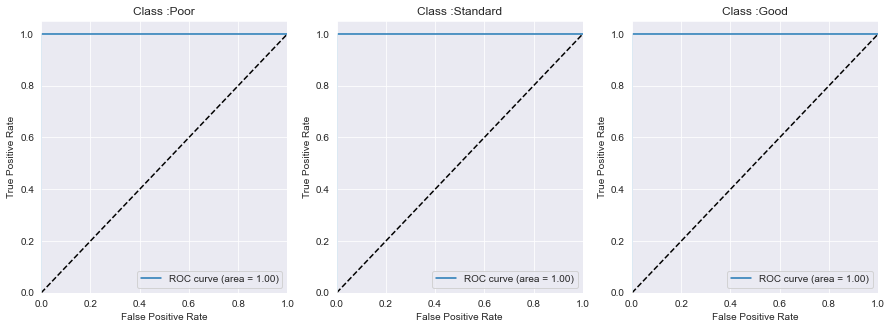

roc_auc_score:  1.0


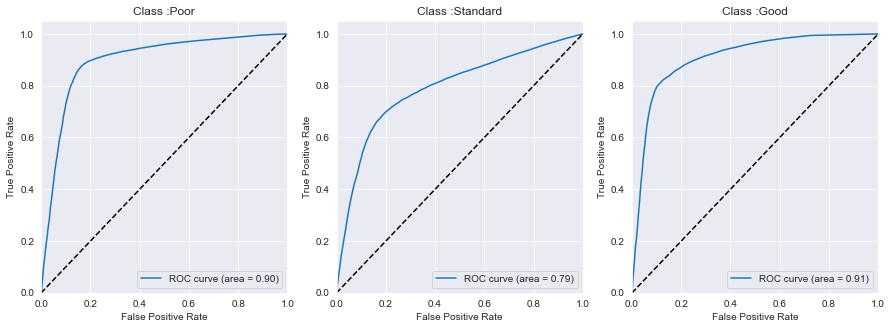

roc_auc_score:  0.8649374832324191


In [14]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

### AUROC OvO 방법

ovo + average='macro' << relatively insensitive to imbalance

**reference**:
- https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
- https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

In [15]:
def calculate_tpr_fpr(y_real, y_pred):
    """
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes

    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    """

    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    """
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.

    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    """
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter=True, ax=None):
    """
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    """
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [16]:
def roc_auc_ovo_plot(X, y, model):

    y_proba = model.predict_proba(X)

    plt.figure(figsize=(20, 8))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovo = {}
    class_combination = [[0, 1], [1, 0], [0, 2], [2, 0], [1, 2], [2, 1]]
    classes = list(model.classes_)

    for i in range(len(class_combination)):
        # gets the class
        comb = class_combination[i]
        c1 = comb[0]
        c2 = comb[1]
        c1_index = classes.index(c1)
        title = f"{c1} vs {c2}"

        # prepares an auxiliary dataframe
        df_aux = pd.DataFrame(X).copy()
        df_aux['class'] = y
        df_aux['prob'] = y_proba[:, c1_index]

        # slices only the subset with both classes
        df_aux = df_aux[ (df_aux['class'] == c1) | (df_aux['class'] == c2)]
        df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
        df_aux = df_aux.reset_index(drop=True)

        # Plot the probability dist for the class and the rest
        ax = plt.subplot(2, 6, i+1)
        sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, bins=bins)
        ax.set_title(title)
        ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
        ax.set_xlabel(f"P(x = {c1})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 6, i+7)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter=False, ax=ax_bottom)
        ax_bottom.set_title("ROC Curve OvO")

        # Calculates the ROC AUC OvO
        roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])

    plt.tight_layout()
    plt.show()

    avg_roc_auc = 0
    i = 0
    for k in roc_auc_ovo:
        avg_roc_auc += roc_auc_ovo[k]
        i += 1
        print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
    print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

    print("sklearn method - average ROC AUC OvO: {:.4f}".format(roc_auc_score(y_true=y, y_score=y_proba, average='macro', multi_class='ovo')))

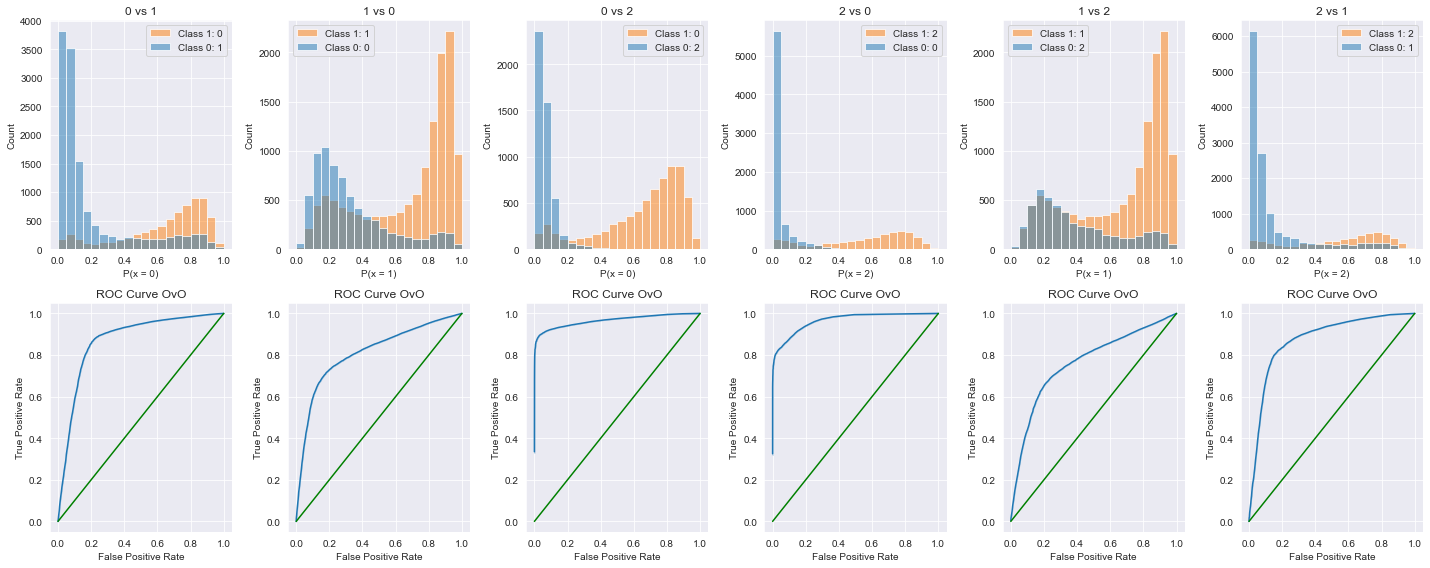

0 vs 1 ROC AUC OvO: 0.8706
1 vs 0 ROC AUC OvO: 0.8107
0 vs 2 ROC AUC OvO: 0.9658
2 vs 0 ROC AUC OvO: 0.9655
1 vs 2 ROC AUC OvO: 0.7627
2 vs 1 ROC AUC OvO: 0.8743
average ROC AUC OvO: 0.8749
sklearn method - average ROC AUC OvO: 0.8749


In [17]:
roc_auc_ovo_plot(x_test, y_test, rfc)

## 2) Scaled Model

In [36]:
from sklearn.preprocessing import RobustScaler

scaling_cols = ['Monthly_Inhand_Salary', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
                'Amount_invested_monthly', 'Monthly_Balance']
rs = RobustScaler()

rs_train_df = train[scaling_cols].copy()
rs_test_df = test[scaling_cols].copy()

rs_train_df = rs.fit_transform(rs_train_df)
rs_test_df = rs.transform(rs_test_df)

train[scaling_cols] = rs_train_df
test[scaling_cols] = rs_test_df

x_train = train.loc[:, all_col_list].values
y_train = train.loc[:, target].values
x_test = test.loc[:, all_col_list].values
y_test = test.loc[:, target].values

In [37]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [38]:
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [39]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [40]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.01 , 0.047, 0.943],
       [0.005, 0.044, 0.951],
       [0.009, 0.042, 0.949],
       ...,
       [0.92 , 0.067, 0.013],
       [0.888, 0.087, 0.025],
       [0.894, 0.084, 0.022]])

In [41]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  1.0
평가 데이터 Accuracy:  0.74164


여전한 과대적합 존재

In [42]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      7216
           1       0.76      0.74      0.75     12960
           2       0.71      0.68      0.69      4824

    accuracy                           0.74     25000
   macro avg       0.73      0.74      0.73     25000
weighted avg       0.74      0.74      0.74     25000



#### AUROC "ovr" 방법

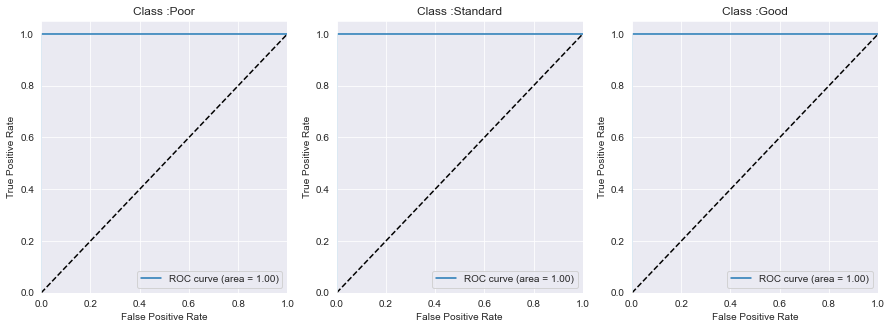

roc_auc_score:  1.0


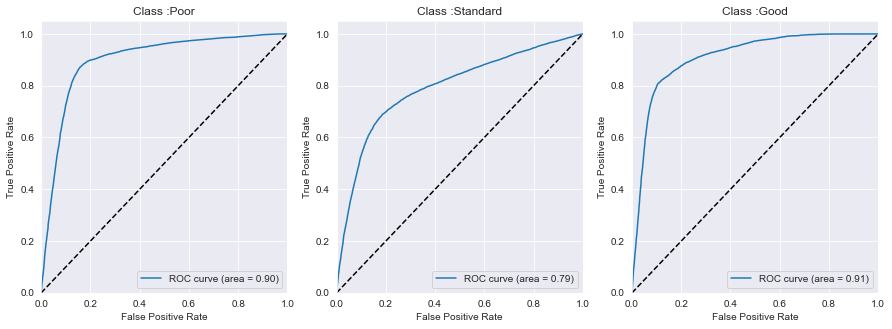

roc_auc_score:  0.8672640630934207


In [43]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

TEST AUROC SCORE OVR 방법으로 소폭 향상 (by 0.23%p)

#### AUROC OvO 방법

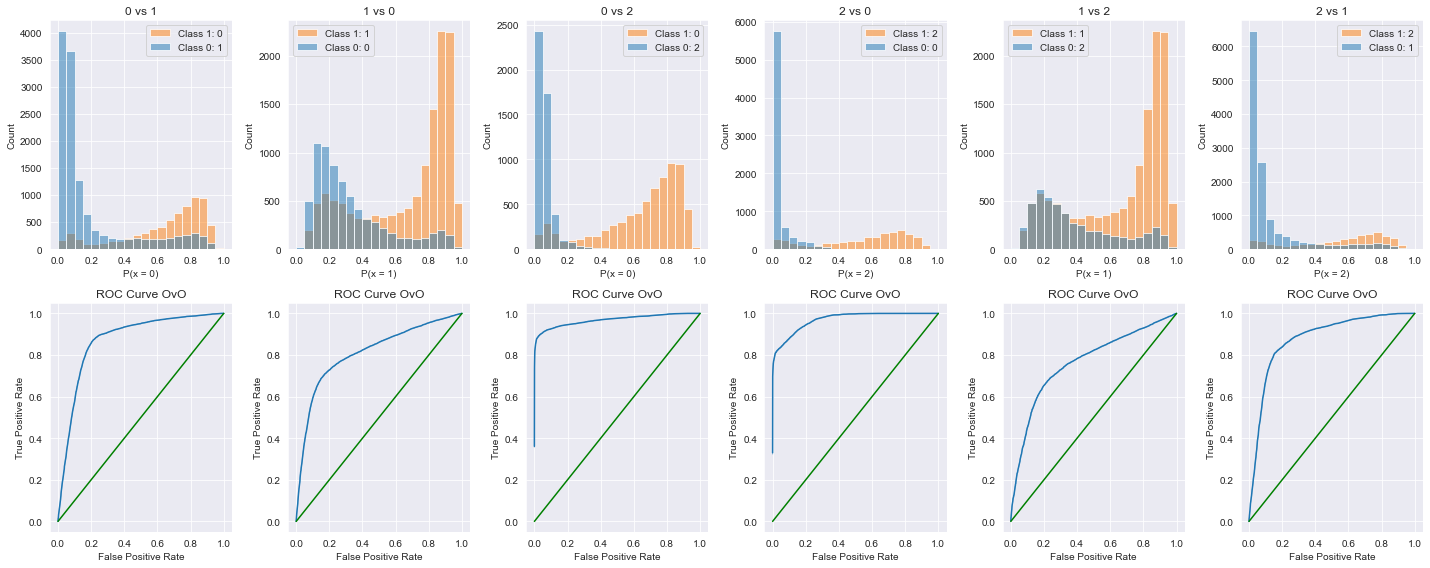

0 vs 1 ROC AUC OvO: 0.8721
1 vs 0 ROC AUC OvO: 0.8120
0 vs 2 ROC AUC OvO: 0.9681
2 vs 0 ROC AUC OvO: 0.9697
1 vs 2 ROC AUC OvO: 0.7647
2 vs 1 ROC AUC OvO: 0.8777
average ROC AUC OvO: 0.8774
sklearn method - average ROC AUC OvO: 0.8774


In [44]:
roc_auc_ovo_plot(x_test, y_test, rfc)

## 3) Cost Weight 방법

### class_weight='balanced'

In [45]:
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced', n_jobs=-1, random_state=42)

In [46]:
rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [47]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [48]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.008, 0.053, 0.939],
       [0.008, 0.032, 0.96 ],
       [0.006, 0.049, 0.945],
       ...,
       [0.887, 0.099, 0.014],
       [0.862, 0.097, 0.041],
       [0.882, 0.086, 0.032]])

In [49]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  1.0
평가 데이터 Accuracy:  0.74052


여전한 과대적합 존재

In [50]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      7216
           1       0.75      0.75      0.75     12960
           2       0.71      0.67      0.69      4824

    accuracy                           0.74     25000
   macro avg       0.73      0.73      0.73     25000
weighted avg       0.74      0.74      0.74     25000



#### AUROC "ovr" 방법

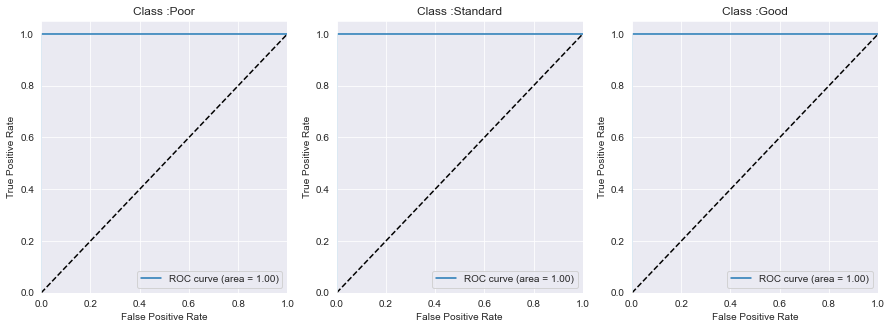

roc_auc_score:  1.0


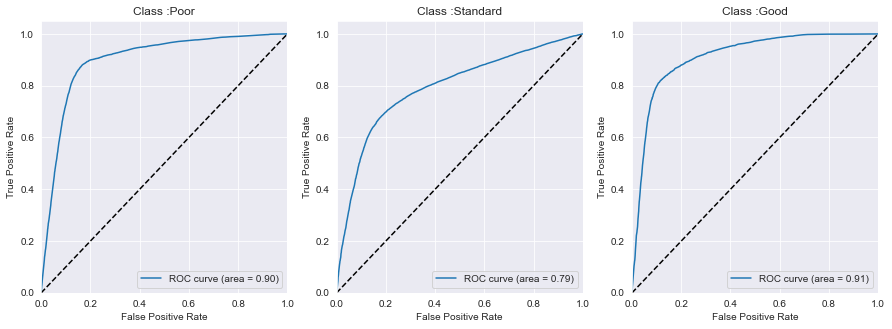

roc_auc_score:  0.8680203032689645


In [51]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

TEST AUROC SCORE OVR 방법으로 소폭 향상 (by 0.3%p)

#### AUROC OvO 방법

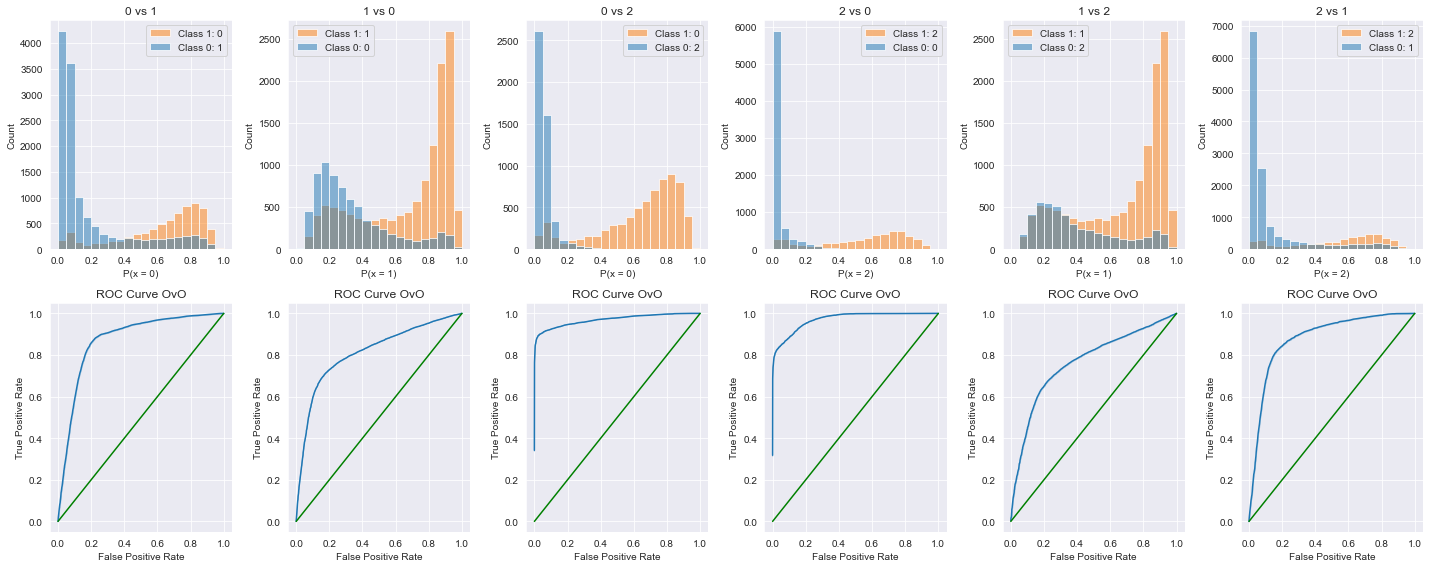

0 vs 1 ROC AUC OvO: 0.8725
1 vs 0 ROC AUC OvO: 0.8122
0 vs 2 ROC AUC OvO: 0.9693
2 vs 0 ROC AUC OvO: 0.9709
1 vs 2 ROC AUC OvO: 0.7646
2 vs 1 ROC AUC OvO: 0.8795
average ROC AUC OvO: 0.8782
sklearn method - average ROC AUC OvO: 0.8782


In [52]:
roc_auc_ovo_plot(x_test, y_test, rfc)

### class_weight='subsample_balanced'

In [161]:
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

In [162]:
rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [163]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [164]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.009, 0.053, 0.938],
       [0.003, 0.033, 0.964],
       [0.005, 0.044, 0.951],
       ...,
       [0.914, 0.066, 0.02 ],
       [0.874, 0.092, 0.034],
       [0.879, 0.094, 0.027]])

In [165]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  1.0
평가 데이터 Accuracy:  0.73976


여전한 과대적합 존재

In [166]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      7216
           1       0.75      0.75      0.75     12960
           2       0.71      0.67      0.69      4824

    accuracy                           0.74     25000
   macro avg       0.73      0.73      0.73     25000
weighted avg       0.74      0.74      0.74     25000



#### AUROC "ovr" 방법

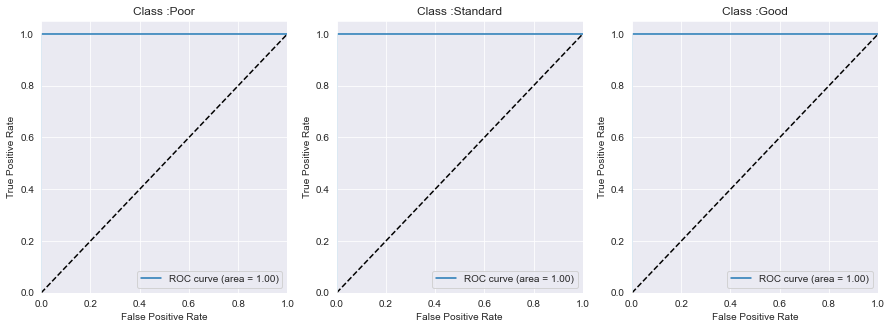

roc_auc_score:  1.0


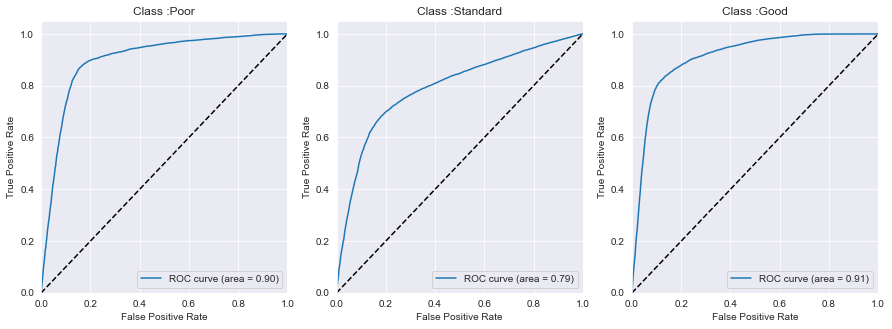

roc_auc_score:  0.868056995566593


In [167]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

TEST AUROC SCORE OVR 방법으로 소폭 향상 (by 0.3%p)

#### AUROC OvO 방법

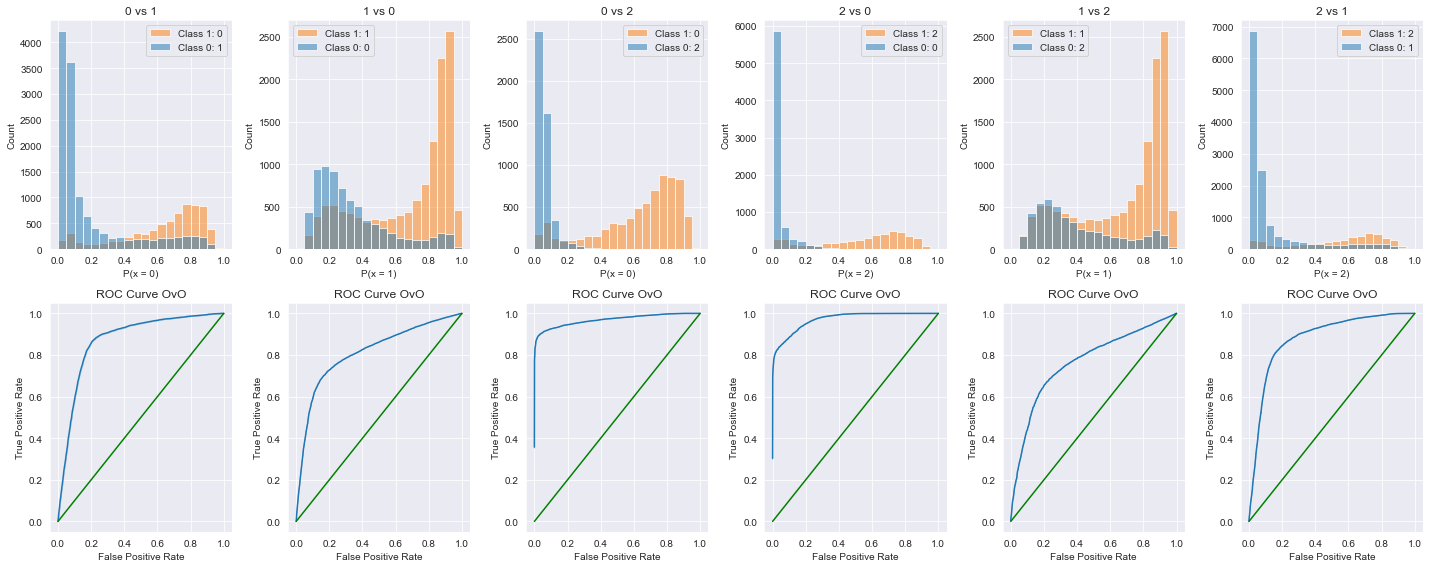

0 vs 1 ROC AUC OvO: 0.8724
1 vs 0 ROC AUC OvO: 0.8126
0 vs 2 ROC AUC OvO: 0.9689
2 vs 0 ROC AUC OvO: 0.9708
1 vs 2 ROC AUC OvO: 0.7652
2 vs 1 ROC AUC OvO: 0.8793
average ROC AUC OvO: 0.8782
sklearn method - average ROC AUC OvO: 0.8782


In [168]:
roc_auc_ovo_plot(x_test, y_test, rfc)

## 4) Re-sampling Method

In [69]:
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours

### SMOTE Only

In [73]:
print(pd.Series(y_train).value_counts())

1    40214
0    21782
2    13004
dtype: int64


In [199]:
smt = SMOTE(k_neighbors=7, random_state=42, sampling_strategy={0: 25000, 1: 40214, 2: 20000})

In [200]:
x_smt, y_smt = smt.fit_resample(x_train, y_train)

In [201]:
pd.Series(y_smt).value_counts()

1    40214
0    25000
2    20000
dtype: int64

In [202]:
rfc = RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=-1, random_state=42)

In [203]:
rfc.fit(x_smt, y_smt)

RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [204]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [205]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.03868897, 0.13280707, 0.82850397],
       [0.03554924, 0.12841129, 0.83603947],
       [0.03393079, 0.12225187, 0.84381734],
       ...,
       [0.91414676, 0.0645276 , 0.02132564],
       [0.85136793, 0.08994859, 0.05868348],
       [0.87747819, 0.08941451, 0.03310731]])

In [206]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  0.9905733333333333
평가 데이터 Accuracy:  0.72496


Accuracy 자체는 성능이 줄었음

In [196]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      7216
           1       0.76      0.71      0.73     12960
           2       0.62      0.70      0.66      4824

    accuracy                           0.72     25000
   macro avg       0.70      0.72      0.71     25000
weighted avg       0.72      0.72      0.72     25000



#### AUROC "ovr" 방법

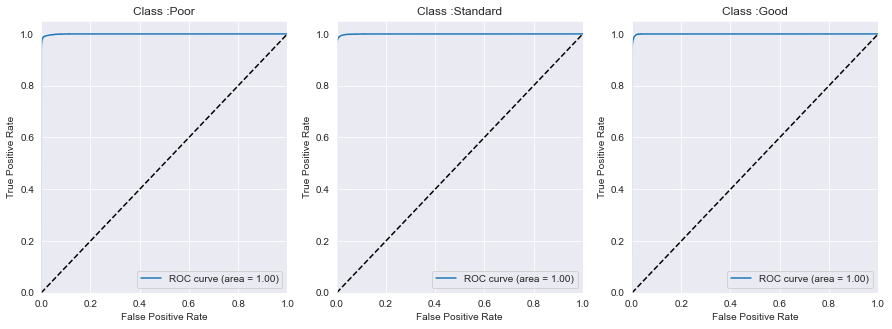

roc_auc_score:  0.9995725649704688


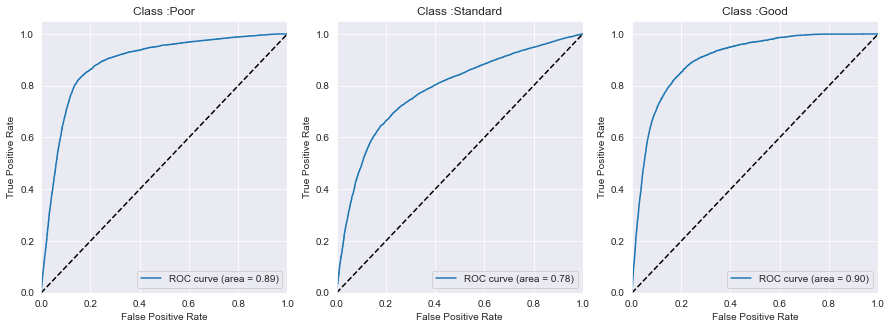

roc_auc_score:  0.8580543386639831


In [197]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

TEST AUROC SCORE OVR 방법으로 성능 소폭 저하

#### AUROC OvO 방법

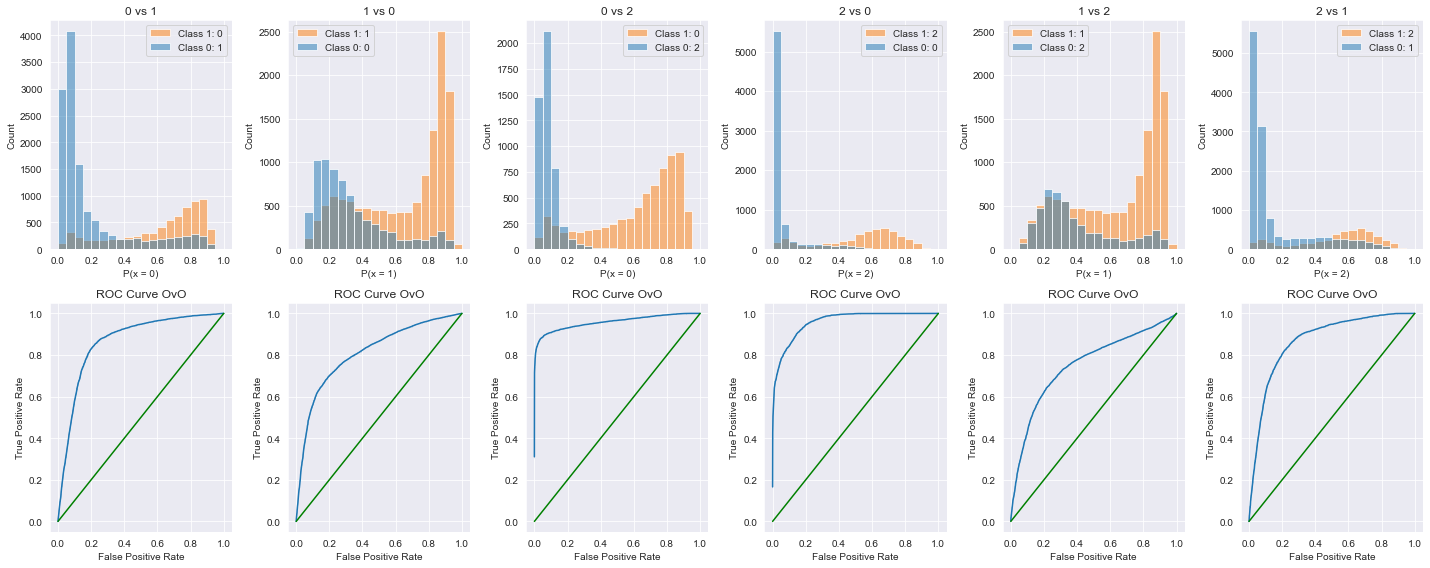

0 vs 1 ROC AUC OvO: 0.8658
1 vs 0 ROC AUC OvO: 0.8099
0 vs 2 ROC AUC OvO: 0.9581
2 vs 0 ROC AUC OvO: 0.9595
1 vs 2 ROC AUC OvO: 0.7528
2 vs 1 ROC AUC OvO: 0.8681
average ROC AUC OvO: 0.8690
sklearn method - average ROC AUC OvO: 0.8690


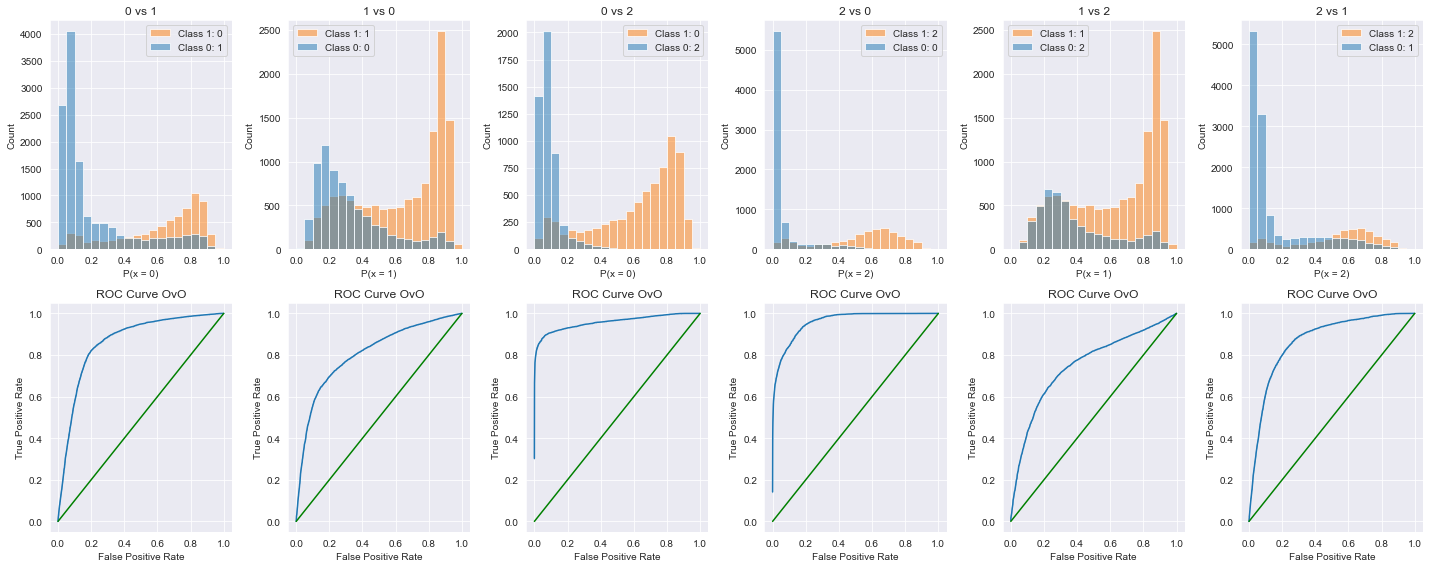

0 vs 1 ROC AUC OvO: 0.8632
1 vs 0 ROC AUC OvO: 0.8076
0 vs 2 ROC AUC OvO: 0.9577
2 vs 0 ROC AUC OvO: 0.9592
1 vs 2 ROC AUC OvO: 0.7512
2 vs 1 ROC AUC OvO: 0.8675
average ROC AUC OvO: 0.8677
sklearn method - average ROC AUC OvO: 0.8677


In [198]:
roc_auc_ovo_plot(x_test, y_test, rfc)

### SMOTE + Cost Sensitive

In [169]:
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

In [170]:
rfc.fit(x_smt, y_smt)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [171]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [172]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.024, 0.087, 0.889],
       [0.009, 0.033, 0.958],
       [0.009, 0.032, 0.959],
       ...,
       [0.904, 0.064, 0.032],
       [0.906, 0.052, 0.042],
       [0.893, 0.08 , 0.027]])

In [173]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  1.0
평가 데이터 Accuracy:  0.72916


Accuracy 자체는 성능이 줄었음

In [174]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      7216
           1       0.76      0.72      0.74     12960
           2       0.66      0.69      0.67      4824

    accuracy                           0.73     25000
   macro avg       0.71      0.73      0.72     25000
weighted avg       0.73      0.73      0.73     25000



#### AUROC "ovr" 방법

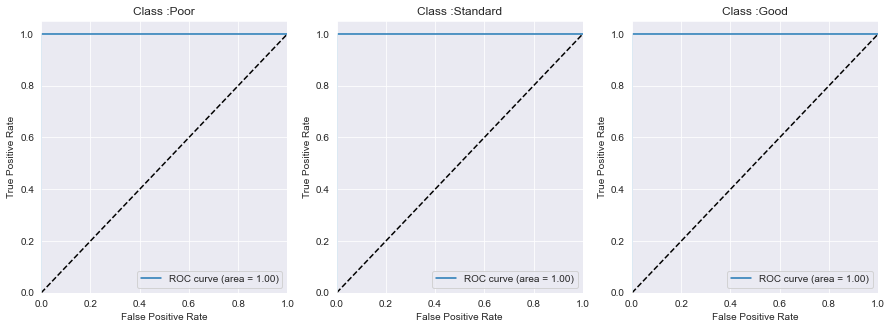

roc_auc_score:  1.0


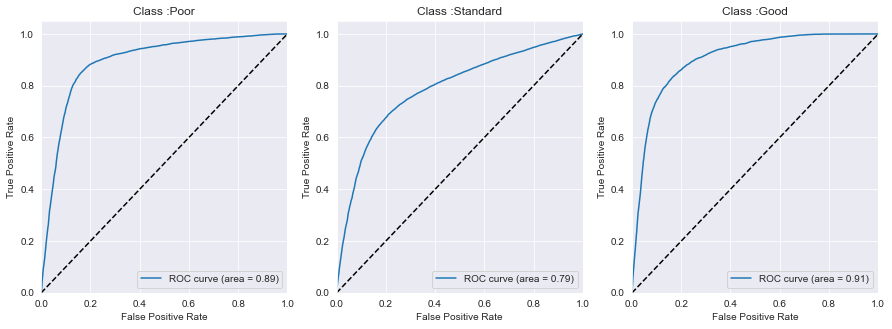

roc_auc_score:  0.8622255101516014


In [175]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

TEST AUROC SCORE OVR 방법으로 성능 소폭 저하

#### AUROC OvO 방법

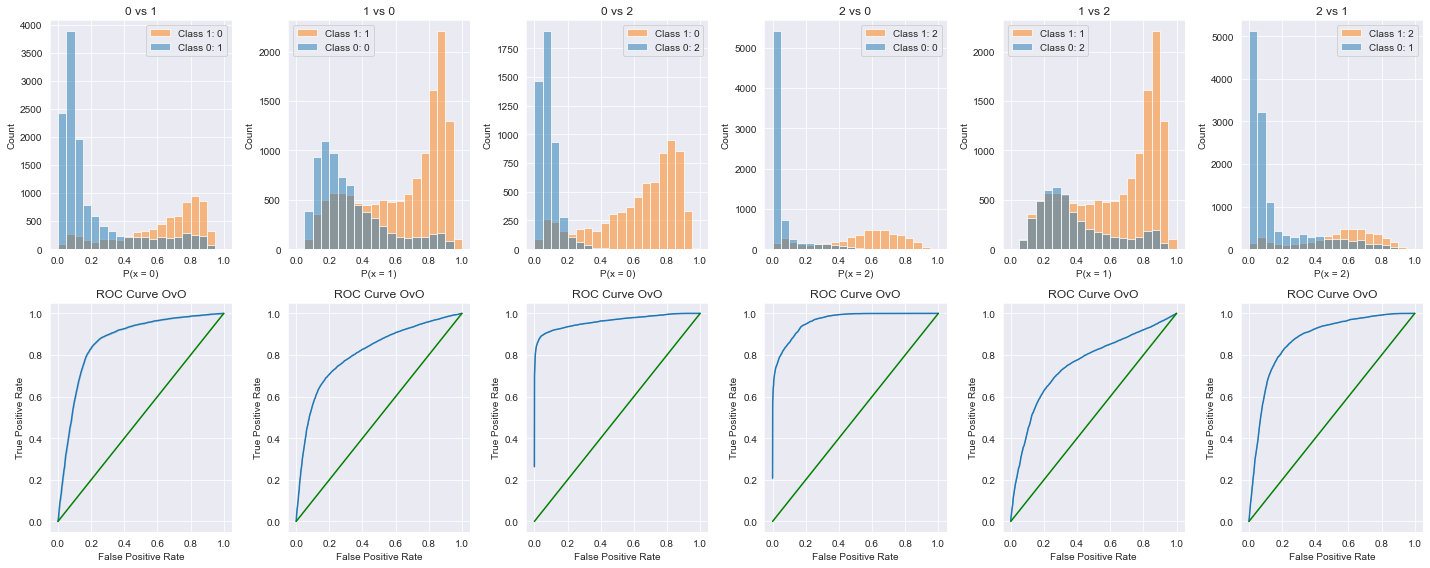

0 vs 1 ROC AUC OvO: 0.8673
1 vs 0 ROC AUC OvO: 0.8104
0 vs 2 ROC AUC OvO: 0.9622
2 vs 0 ROC AUC OvO: 0.9645
1 vs 2 ROC AUC OvO: 0.7549
2 vs 1 ROC AUC OvO: 0.8726
average ROC AUC OvO: 0.8720
sklearn method - average ROC AUC OvO: 0.8720


In [176]:
roc_auc_ovo_plot(x_test, y_test, rfc)

### SMOTENC Only

In [100]:
def sampling_smote_enc(x_input_df, y_input_df, categorical_cols, sampling_strategy='auto'):
    """
    카테고리 형식에 강한 smote 방법

    params:
      x_input_df: 샘플링 원하는 x데이터프레임
      y_input_df: 샘플링 원하는 y데이터프레임
      categorical_cols : 카테고리 컬럼명 리스트  ex) [ 'Credit_Mix', 'Credit_History_Age','Payment_of_Min_Amount', 'Payment_Behaviour']
      sampling_strategy : 샘플링 비율            ex ) {0: 30000, 1: 40214, 2: 25000}
    return :
      샘플링 완료된 x, y 데이터프레임

    사용예시 :
      output_x, output_y = sampling_smote(x_train,y_train)

    참고:
    https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html
    """

    # 카테고리 데이터 index 번호 생성
    # cat_col_idx = [list(x_input_df.columns).index(col) for col in categorical_cols]
    cat_col_idx = categorical_cols

    #sampling fit
    smote_clf = SMOTENC(random_state=42, categorical_features= cat_col_idx, sampling_strategy=sampling_strategy)
    x_sampling_df, y_sampling_df = smote_clf.fit_resample(x_input_df, y_input_df)

    # result print
    print('=========== shape ===========')
    print('before shape : ',x_input_df.shape, y_input_df.shape)
    print('after shape : ',x_sampling_df.shape, y_sampling_df.shape)

    print('\n\n=========== value_counts ===========')
    print('before shape : ' ,dict(pd.Series(y_input_df).value_counts()))
    print('after shape : ',dict(pd.Series(y_sampling_df).value_counts()))

    #result return
    return x_sampling_df, y_sampling_df

In [101]:
x_sme, y_sme = sampling_smote_enc(x_train, y_train, cat_col_idx, sampling_strategy={0: 25000, 1: 40214, 2: 18000})

=========== shape ===========
before shape :  (75000, 21) (75000,)
after shape :  (83214, 21) (83214,)


=========== value_counts ===========
before shape :  {1: 40214, 0: 21782, 2: 13004}
after shape :  {1: 40214, 0: 25000, 2: 18000}


In [102]:
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

In [104]:
rfc.fit(x_sme, y_sme)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=-1, random_state=42)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [105]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [106]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.01 , 0.04 , 0.95 ],
       [0.006, 0.031, 0.963],
       [0.004, 0.03 , 0.966],
       ...,
       [0.914, 0.062, 0.024],
       [0.876, 0.074, 0.05 ],
       [0.884, 0.085, 0.031]])

In [107]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  1.0
평가 데이터 Accuracy:  0.74192


dd?

In [108]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      7216
           1       0.76      0.74      0.75     12960
           2       0.70      0.69      0.70      4824

    accuracy                           0.74     25000
   macro avg       0.73      0.74      0.73     25000
weighted avg       0.74      0.74      0.74     25000



#### AUROC "ovr" 방법

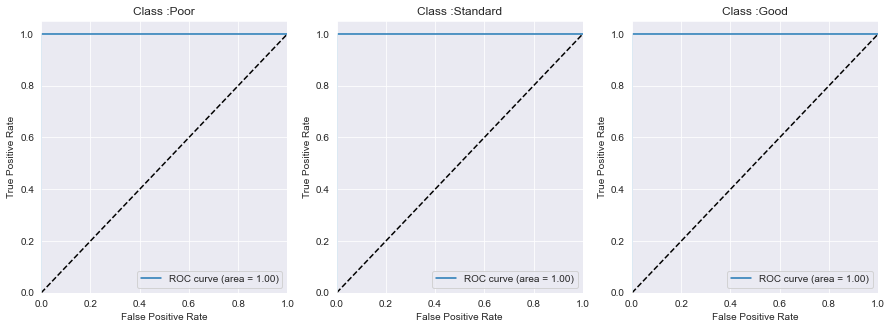

roc_auc_score:  1.0


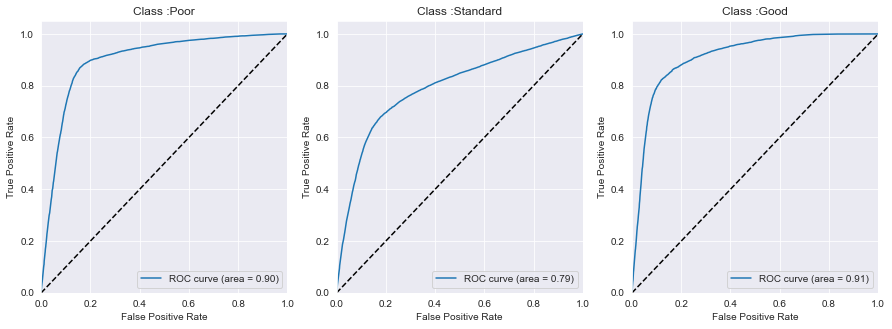

roc_auc_score:  0.8679457500508289


In [109]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

TEST AUROC SCORE OVR 방법으로 성능 소폭 저하

#### AUROC OvO 방법

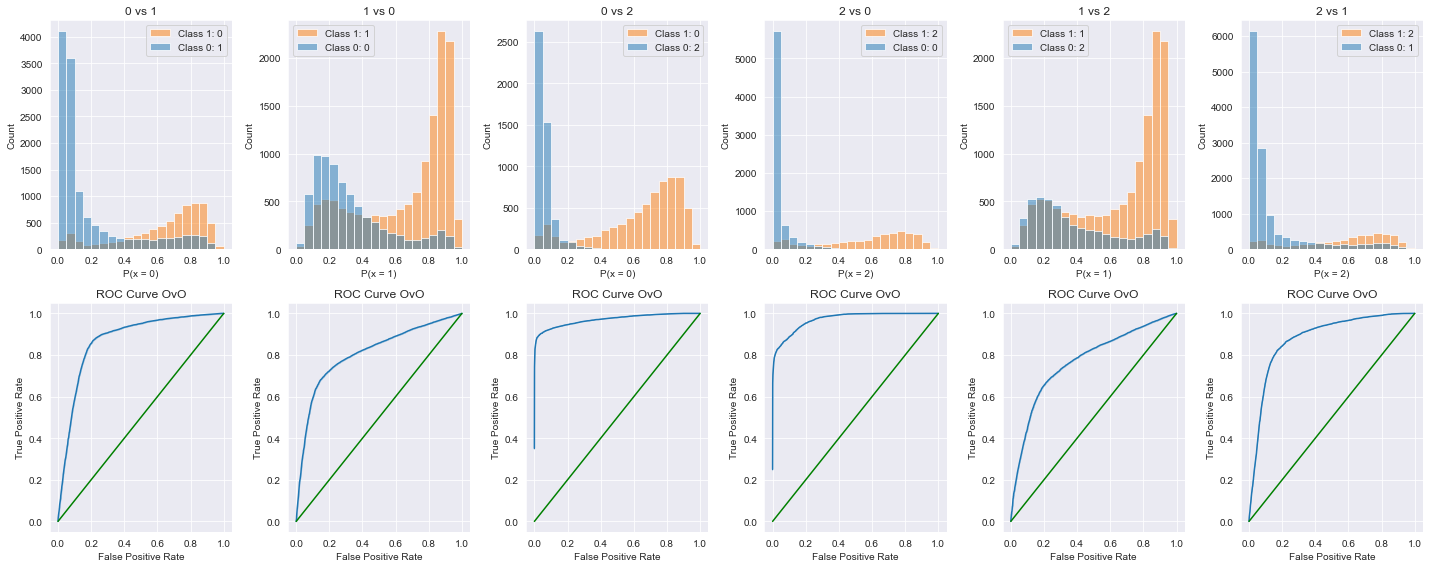

0 vs 1 ROC AUC OvO: 0.8724
1 vs 0 ROC AUC OvO: 0.8091
0 vs 2 ROC AUC OvO: 0.9701
2 vs 0 ROC AUC OvO: 0.9709
1 vs 2 ROC AUC OvO: 0.7691
2 vs 1 ROC AUC OvO: 0.8790
average ROC AUC OvO: 0.8784
sklearn method - average ROC AUC OvO: 0.8784


In [110]:
roc_auc_ovo_plot(x_test, y_test, rfc)

## 5) Hybrid Method

### SMOTE + ENN

In [111]:
def sampling_smote_enn(x_input, y_input, smote=None, enn=None, sampling_strategy='auto'):
    """
    :param x_input: x data 입력
    :param y_input: y data 입력
    :param smote: SMOTE 객체 입력
    :param enn: ENN 객체 입력
    :param sampling_strategy: 딕셔너리 구조로 입력
    :return: x_sme, y_sme
    """
    import pandas as pd
    from imblearn.combine import SMOTEENN
    sme = SMOTEENN(smote=smote,
                   enn=enn,
                   sampling_strategy=sampling_strategy,
                   random_state=42,
                   n_jobs=-1)

    x_sme, y_sme = sme.fit_resample(x_input, y_input)

    print("Before SMOTE ENN....")
    print("The shape of your X data: ", x_input.shape)
    print("The shape of your y data: ", y_input.shape)
    print("Label Counts : \n", pd.Series(y_input).value_counts().sort_index())
    print('\n')
    print("After SMOTE ENN Applied....")
    print("The shape of your X_SME data: ", x_sme.shape)
    print("The shape of your y_SME data: ", y_sme.shape)
    print("Label Counts : \n", pd.Series(y_sme).value_counts().sort_index())

    return x_sme, y_sme

In [112]:
x_smte, y_smte = sampling_smote_enn(x_train, y_train)

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (96737, 21)
The shape of your y_SME data:  (96737,)
Label Counts : 
 0    31975
1    28511
2    36251
dtype: int64


바닐라 모델은 Sampling 결과가 Major Class가 Minor보다 작아지는 기현상이 나타남.

In [113]:
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

In [115]:
rfc.fit(x_smte, y_smte)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [116]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [117]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.025, 0.06 , 0.915],
       [0.004, 0.021, 0.975],
       [0.004, 0.019, 0.977],
       ...,
       [0.981, 0.005, 0.014],
       [0.893, 0.049, 0.058],
       [0.954, 0.008, 0.038]])

In [118]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  0.8638
평가 데이터 Accuracy:  0.69848


dd?

In [119]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      7216
           1       0.77      0.65      0.71     12960
           2       0.57      0.74      0.64      4824

    accuracy                           0.70     25000
   macro avg       0.68      0.72      0.69     25000
weighted avg       0.71      0.70      0.70     25000



#### AUROC "ovr" 방법

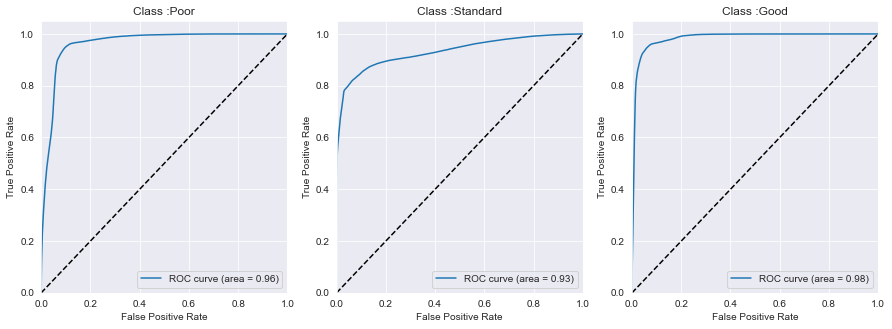

roc_auc_score:  0.9591438968453919


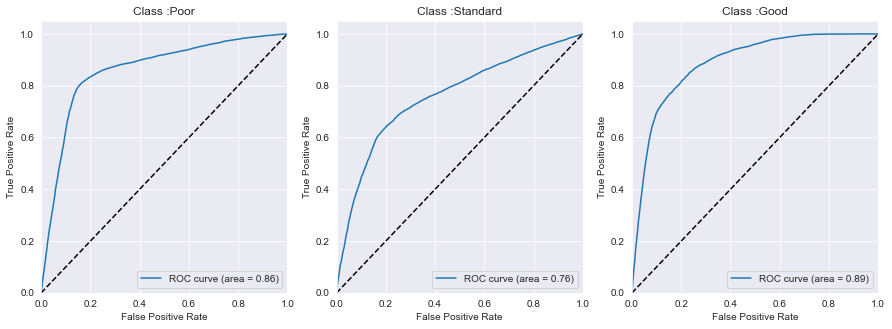

roc_auc_score:  0.8358012125580659


In [120]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

plain 방법으로는 상당한 성능저하가 있음 ENN 알고리즘에 의해 major class의 정보 유실이 크다는 방증임

#### AUROC OvO 방법

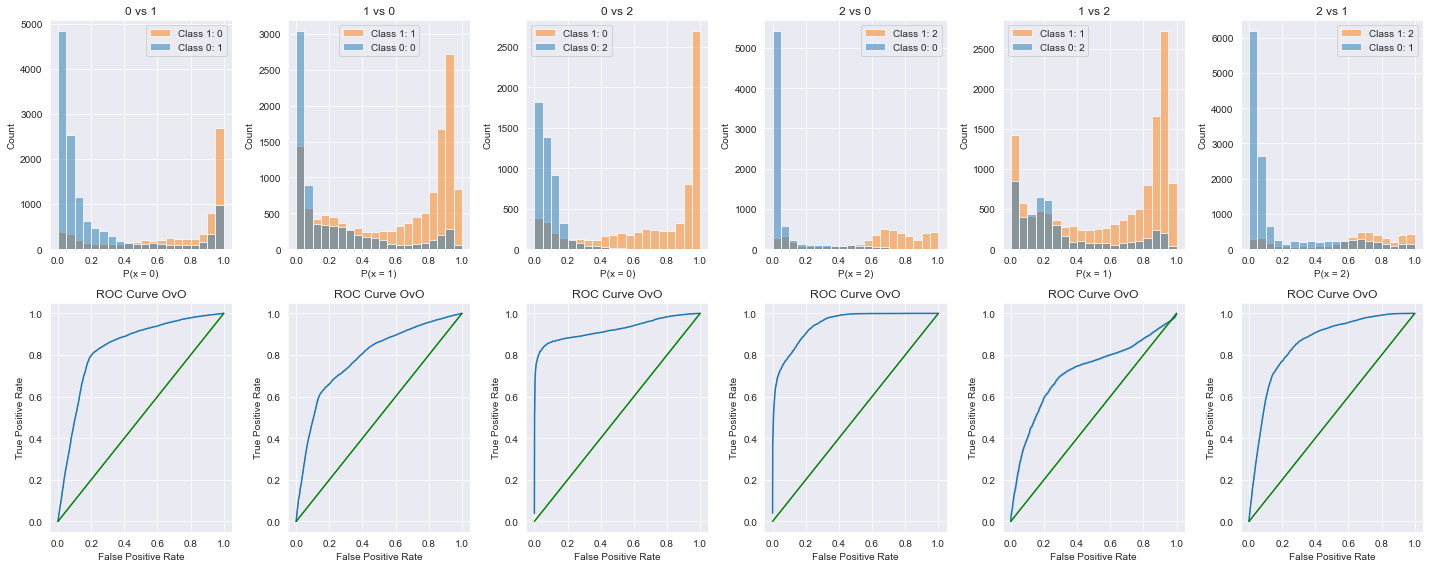

0 vs 1 ROC AUC OvO: 0.8362
1 vs 0 ROC AUC OvO: 0.7878
0 vs 2 ROC AUC OvO: 0.9236
2 vs 0 ROC AUC OvO: 0.9465
1 vs 2 ROC AUC OvO: 0.7192
2 vs 1 ROC AUC OvO: 0.8542
average ROC AUC OvO: 0.8446
sklearn method - average ROC AUC OvO: 0.8446


In [121]:
roc_auc_ovo_plot(x_test, y_test, rfc)

### More Flexible Hybrid Sampling

조금 더 유연한 방법을 활용 Major class가 Minor Class에 역전되는 현상을 막아야함

sklearn reference에서는 SMOTE ENN이 Noisy 제거에 SMOTETomek 보다 나은 결과를 제시한다고 말하고 있음

#### SMOTE + ENN 비율 조정

In [129]:
smt = SMOTE(k_neighbors=7, sampling_strategy={0: 30000, 1: 40214, 2: 25000}, random_state=42, n_jobs=-1)
# smt = SMOTE(k_neighbors=7, random_state=42, n_jobs=-1)

In [130]:
x_smte, y_smte = sampling_smote_enn(x_train, y_train, smt)

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (68244, 21)
The shape of your y_SME data:  (68244,)
Label Counts : 
 0    20344
1    28557
2    19343
dtype: int64


In [131]:
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

In [132]:
rfc.fit(x_smte, y_smte)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [133]:
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

In [134]:
y_proba = rfc.predict_proba(x_test)
y_proba

y_proba_train = rfc.predict_proba(x_train)
y_proba_train

array([[0.022, 0.059, 0.919],
       [0.009, 0.02 , 0.971],
       [0.006, 0.014, 0.98 ],
       ...,
       [0.833, 0.044, 0.123],
       [0.883, 0.047, 0.07 ],
       [0.905, 0.028, 0.067]])

In [135]:
print('훈련 데이터 Accuracy : ', rfc.score(x_train, y_train))
print('평가 데이터 Accuracy: ', rfc.score(x_test, y_test))

훈련 데이터 Accuracy :  0.8520533333333333
평가 데이터 Accuracy:  0.70564


dd?

In [136]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      7216
           1       0.76      0.68      0.72     12960
           2       0.60      0.70      0.65      4824

    accuracy                           0.71     25000
   macro avg       0.69      0.71      0.70     25000
weighted avg       0.71      0.71      0.71     25000



##### AUROC "ovr" 방법

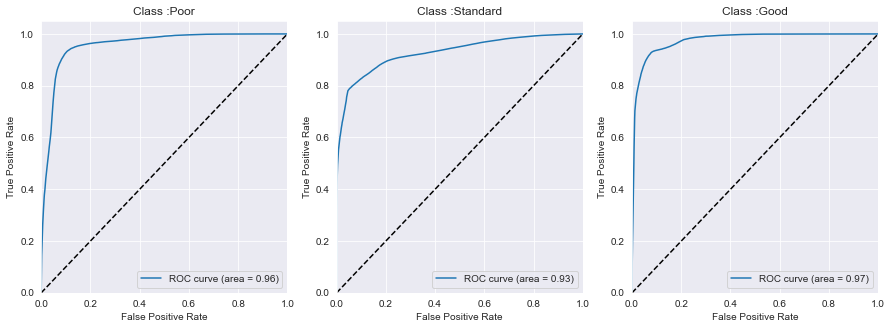

roc_auc_score:  0.9527358892592473


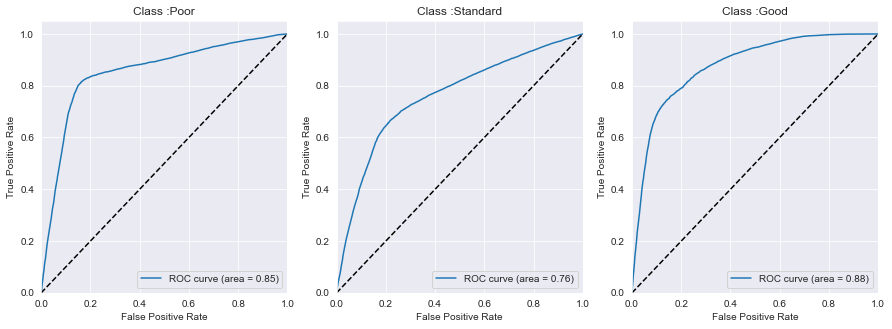

roc_auc_score:  0.8295522835565419


In [137]:
roc_curve_plot(x_train, y_train, rfc)

roc_curve_plot(x_test, y_test, rfc)

plain 방법으로는 상당한 성능저하가 있음 ENN 알고리즘에 의해 major class의 정보 유실이 크다는 방증임

##### AUROC OvO 방법

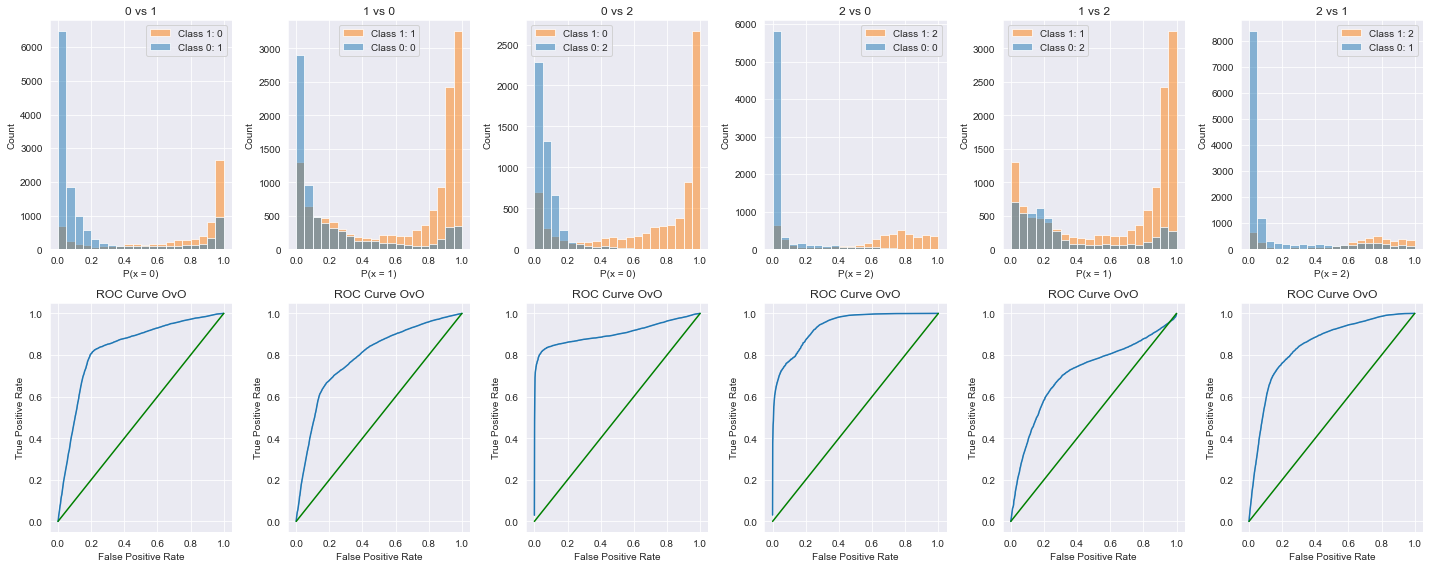

0 vs 1 ROC AUC OvO: 0.8320
1 vs 0 ROC AUC OvO: 0.7900
0 vs 2 ROC AUC OvO: 0.9044
2 vs 0 ROC AUC OvO: 0.9369
1 vs 2 ROC AUC OvO: 0.7151
2 vs 1 ROC AUC OvO: 0.8436
average ROC AUC OvO: 0.8370
sklearn method - average ROC AUC OvO: 0.8370


In [138]:
roc_auc_ovo_plot(x_test, y_test, rfc)

### SMOTENC + ENN + Cost Sensitive

In [122]:
def hybrid_sampling_and_classification(over_sampler, under_sampler, clf, X, y):
    """
    :param over_sample: 생성된 oversampling 객체
    :param under_sampler: 생성된 undersampling 객체
    :param clf: 분류기
    :return: pipeline 객체

    활용 예시)
    smote = SMOTE()
    rus = RandomUnderSampling()
    rf = RandomForest()
    pipeline = hybrid_sampling_and_classification(smote, rus, rf, x_train, y_train)
    y_pred = pipeline.predict(x_test)
    accuracy_score(y_test, y_pred)
    """

    from imblearn.pipeline import Pipeline
    pipeline = Pipeline(steps=[('o', over_sampler), ('u', under_sampler), ('m', clf)])
    pipeline.fit(X, y)

    return pipeline

In [139]:
def show_results(pipeline, x_train, y_train, x_test, y_test):
    """

    :param pipeline: learned object
    :param x_train: x train input
    :param y_train: y train
    :param x_test: x test input
    :param y_test: y test
    :return: None
    """
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    y_train_pred = pipeline.predict(x_train)
    y_test_pred = pipeline.predict(x_test)

    print('Accuracy Score (Train): ', accuracy_score(y_train, y_train_pred))
    print('Accuracy Score (Test): ', accuracy_score(y_test, y_test_pred))

    print('Classification Report....: ')
    print(classification_report(y_test, y_test_pred))

    print('Confusion Matrix...: ')
    print(confusion_matrix(y_test, y_test_pred))

In [140]:
cat_col_idx = [0, 1, 12, 15, 16, 19]

In [141]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

smoteen = SMOTENC(random_state=42, categorical_features=cat_col_idx, sampling_strategy={0: 25000, 1: 40214, 2: 20000})
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

In [142]:
pipeline = hybrid_sampling_and_classification(smoteen, enn, model, x_train, y_train)

/Users/ben/miniforge3/envs/tf_mini/lib/python3.8/site-packages/imblearn/under_sampling/_prototype_selection/_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
/Users/ben/miniforge3/envs/tf_mini/lib/python3.8/site-packages/imblearn/under_sampling/_prototype_selection/_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis`

In [143]:
show_results(pipeline, x_train, y_train, x_test, y_test)

Accuracy Score (Train):  0.9076533333333333
Accuracy Score (Test):  0.73808
Classification Report....: 
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      7216
           1       0.78      0.70      0.74     12960
           2       0.67      0.75      0.71      4824

    accuracy                           0.74     25000
   macro avg       0.72      0.75      0.74     25000
weighted avg       0.74      0.74      0.74     25000

Confusion Matrix...: 
[[5801 1312  103]
 [2259 9017 1684]
 [  28 1162 3634]]


##### AUROC "ovr" 방법

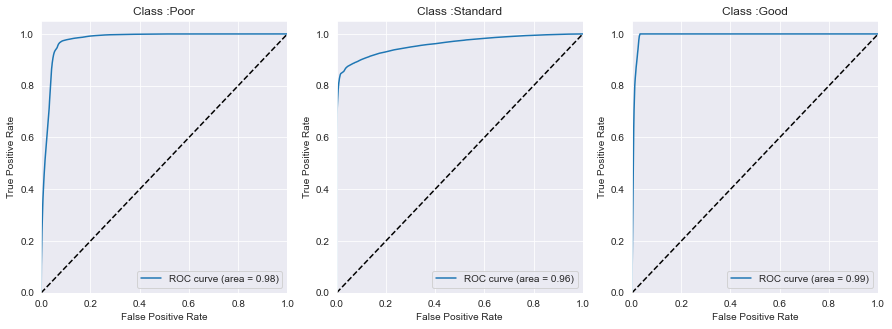

roc_auc_score:  0.9762652281248189


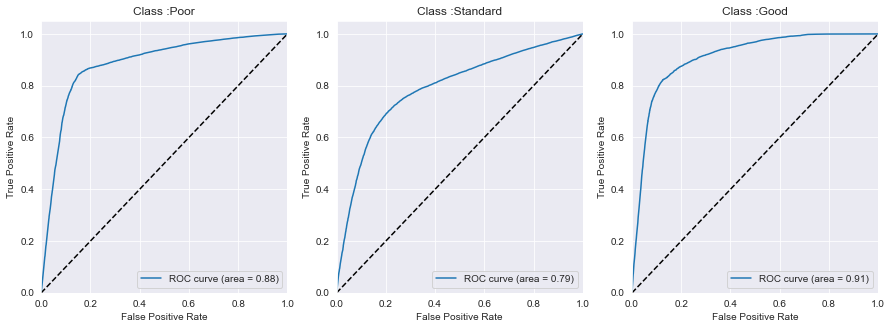

roc_auc_score:  0.8612918279176501


In [144]:
roc_curve_plot(x_train, y_train, pipeline)

roc_curve_plot(x_test, y_test, pipeline)

TEST AUROC SCORE OVR 방법으로 성능 소폭 저하

##### AUROC OvO 방법

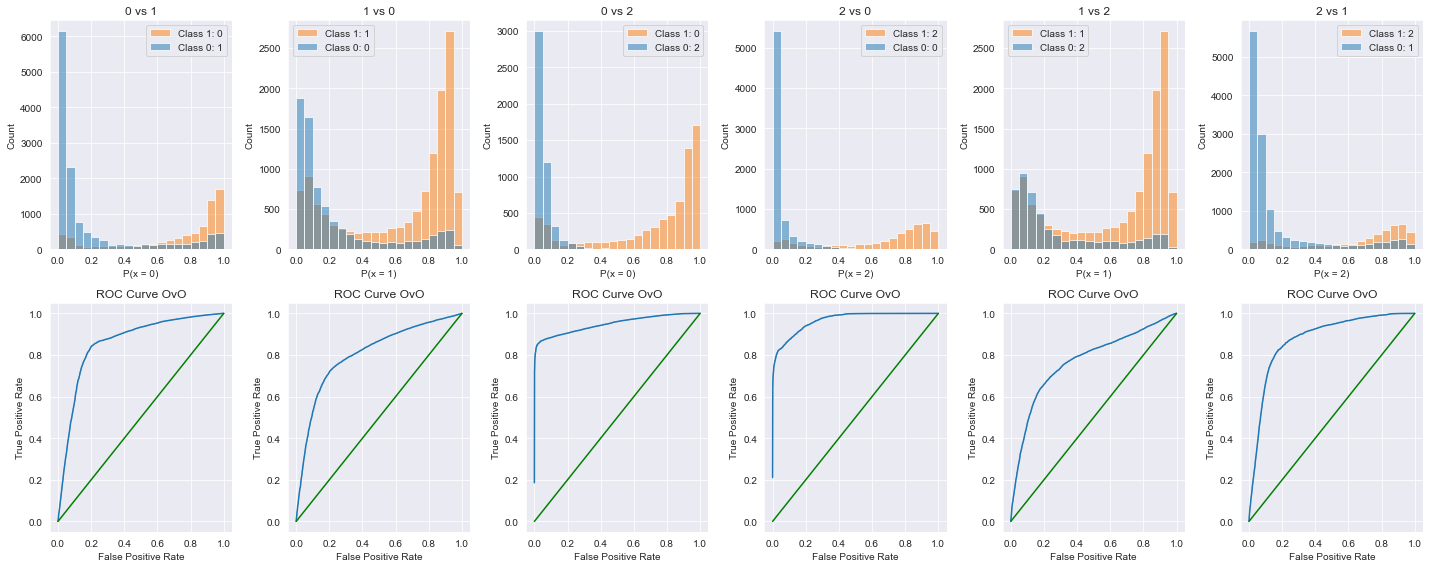

0 vs 1 ROC AUC OvO: 0.8600
1 vs 0 ROC AUC OvO: 0.8052
0 vs 2 ROC AUC OvO: 0.9486
2 vs 0 ROC AUC OvO: 0.9666
1 vs 2 ROC AUC OvO: 0.7688
2 vs 1 ROC AUC OvO: 0.8774
average ROC AUC OvO: 0.8711
sklearn method - average ROC AUC OvO: 0.8711


In [145]:
roc_auc_ovo_plot(x_test, y_test, pipeline)

### Borderline SMOTE + ENN + Cost Sensitive

In [146]:
from imblearn.over_sampling import BorderlineSMOTE

In [147]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

# bsmote = BorderlineSMOTE(sampling_strategy={0: 25000, 1: 40214, 2: 20000}, random_state=42, k_neighbors=7, n_jobs=-1)
bsmote = BorderlineSMOTE(random_state=42, k_neighbors=7, n_jobs=-1)
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

In [148]:
pipeline = hybrid_sampling_and_classification(bsmote, enn, model, x_train, y_train)

/Users/ben/miniforge3/envs/tf_mini/lib/python3.8/site-packages/imblearn/under_sampling/_prototype_selection/_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)
/Users/ben/miniforge3/envs/tf_mini/lib/python3.8/site-packages/imblearn/under_sampling/_prototype_selection/_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis`

In [149]:
show_results(pipeline, x_train, y_train, x_test, y_test)

Accuracy Score (Train):  0.9092266666666666
Accuracy Score (Test):  0.72448
Classification Report....: 
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      7216
           1       0.80      0.66      0.72     12960
           2       0.62      0.76      0.68      4824

    accuracy                           0.72     25000
   macro avg       0.71      0.75      0.72     25000
weighted avg       0.74      0.72      0.72     25000

Confusion Matrix...: 
[[5928 1026  262]
 [2419 8513 2028]
 [  45 1108 3671]]


##### AUROC "ovr" 방법

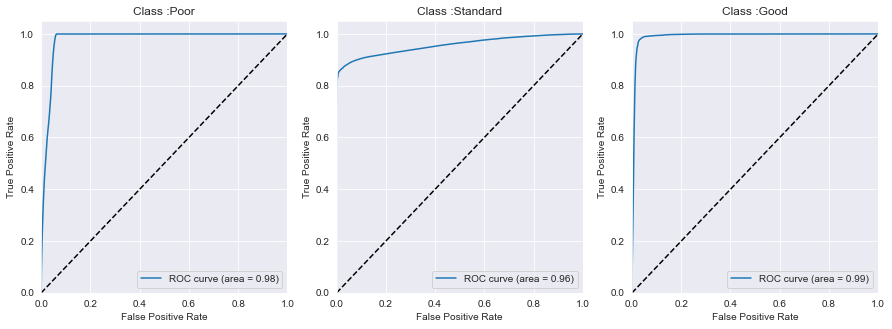

roc_auc_score:  0.975288934055917


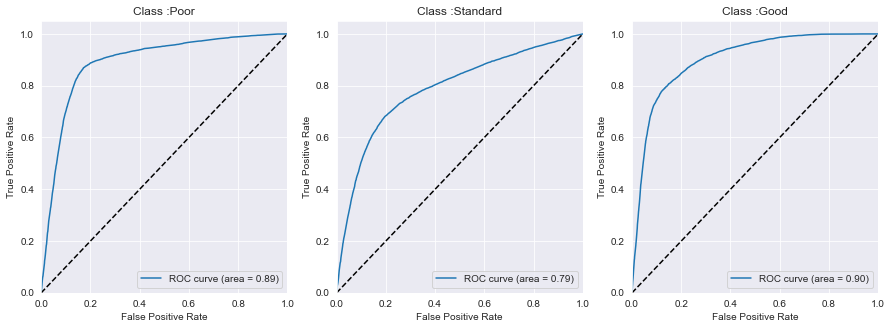

roc_auc_score:  0.8600461271607834


In [150]:
roc_curve_plot(x_train, y_train, pipeline)

roc_curve_plot(x_test, y_test, pipeline)

TEST AUROC SCORE OVR 방법으로 성능 소폭 저하

##### AUROC OvO 방법

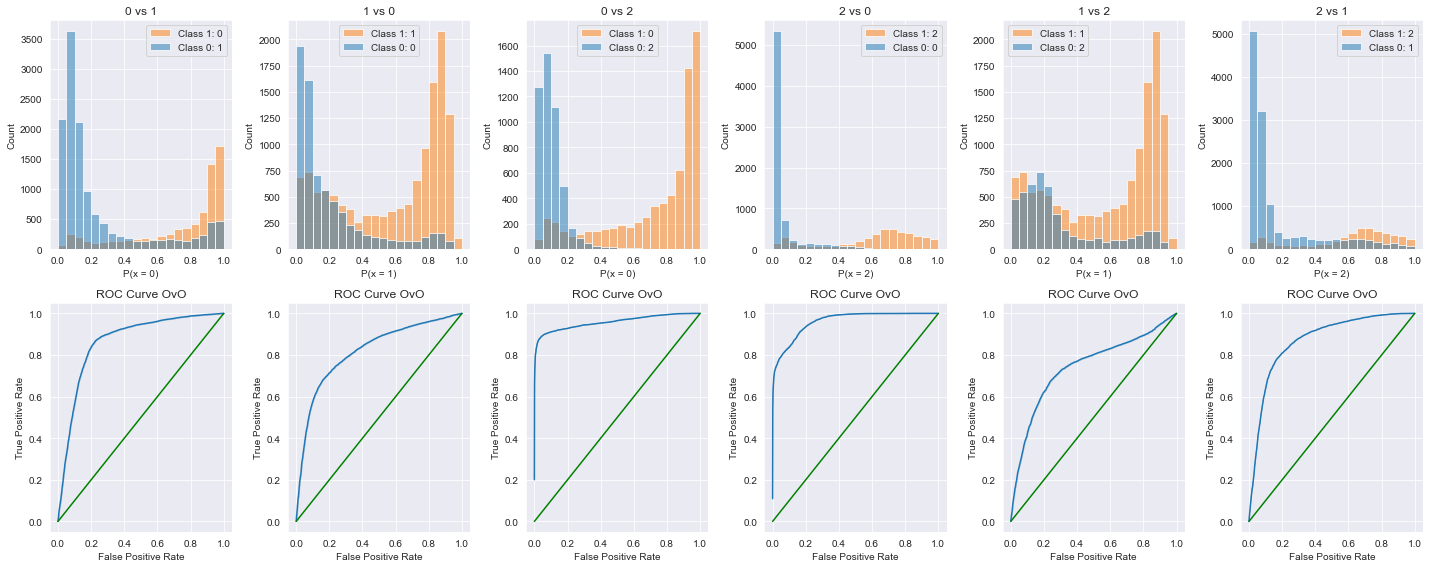

0 vs 1 ROC AUC OvO: 0.8655
1 vs 0 ROC AUC OvO: 0.8178
0 vs 2 ROC AUC OvO: 0.9579
2 vs 0 ROC AUC OvO: 0.9606
1 vs 2 ROC AUC OvO: 0.7426
2 vs 1 ROC AUC OvO: 0.8692
average ROC AUC OvO: 0.8689
sklearn method - average ROC AUC OvO: 0.8689


In [151]:
roc_auc_ovo_plot(x_test, y_test, pipeline)

### Borderline SMOTE + RUS + Cost Sensitive

In [152]:
from imblearn.under_sampling import RandomUnderSampler

In [154]:
bsmote = BorderlineSMOTE(sampling_strategy={0: 35000, 1:40214, 2:30000}, random_state=42, n_jobs=-1)
rus = RandomUnderSampler(sampling_strategy={0: 30000, 1: 35000, 2: 30000}, random_state=42)

In [155]:
x_smt, y_smt = bsmote.fit_resample(x_train, y_train)
print(pd.Series(y_smt).value_counts(()))

x_smt_rus, y_smt_rus = rus.fit_resample(x_smt, y_smt)
print(pd.Series(y_smt_rus).value_counts())

1    40214
0    35000
2    30000
dtype: int64
1    35000
0    30000
2    30000
dtype: int64


In [156]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', random_state=42, n_jobs=-1)

In [157]:
pipeline = hybrid_sampling_and_classification(bsmote, rus, model, x_train, y_train)

In [158]:
show_results(pipeline, x_train, y_train, x_test, y_test)

Accuracy Score (Train):  0.98088
Accuracy Score (Test):  0.72308
Classification Report....: 
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      7216
           1       0.76      0.70      0.73     12960
           2       0.63      0.72      0.67      4824

    accuracy                           0.72     25000
   macro avg       0.71      0.73      0.72     25000
weighted avg       0.73      0.72      0.72     25000

Confusion Matrix...: 
[[5483 1487  246]
 [2048 9136 1776]
 [  29 1337 3458]]


##### AUROC "ovr" 방법

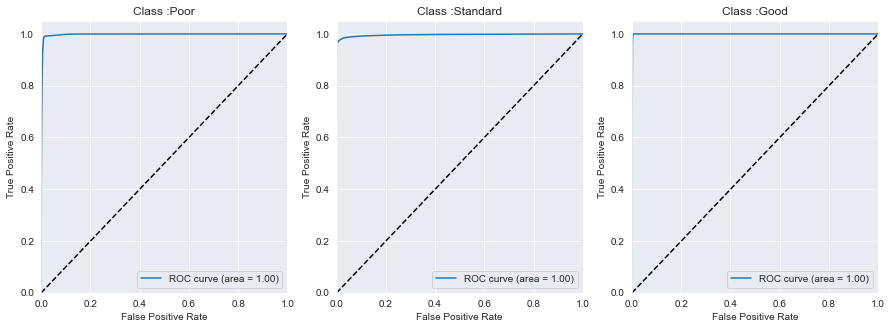

roc_auc_score:  0.9979378897811961


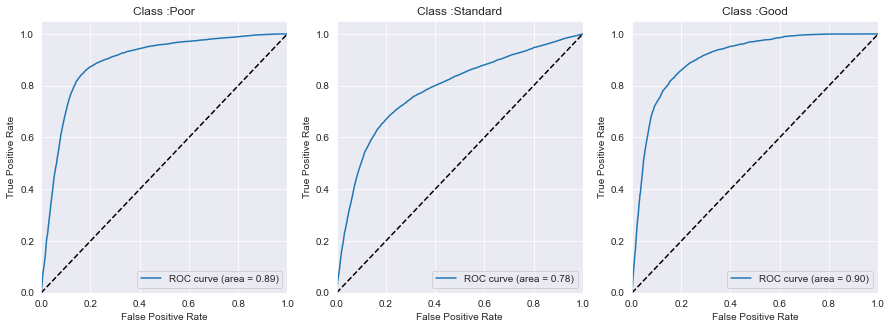

roc_auc_score:  0.8599068668015543


In [159]:
roc_curve_plot(x_train, y_train, pipeline)

roc_curve_plot(x_test, y_test, pipeline)

TEST AUROC SCORE OVR 방법으로 성능 소폭 저하

##### AUROC OvO 방법

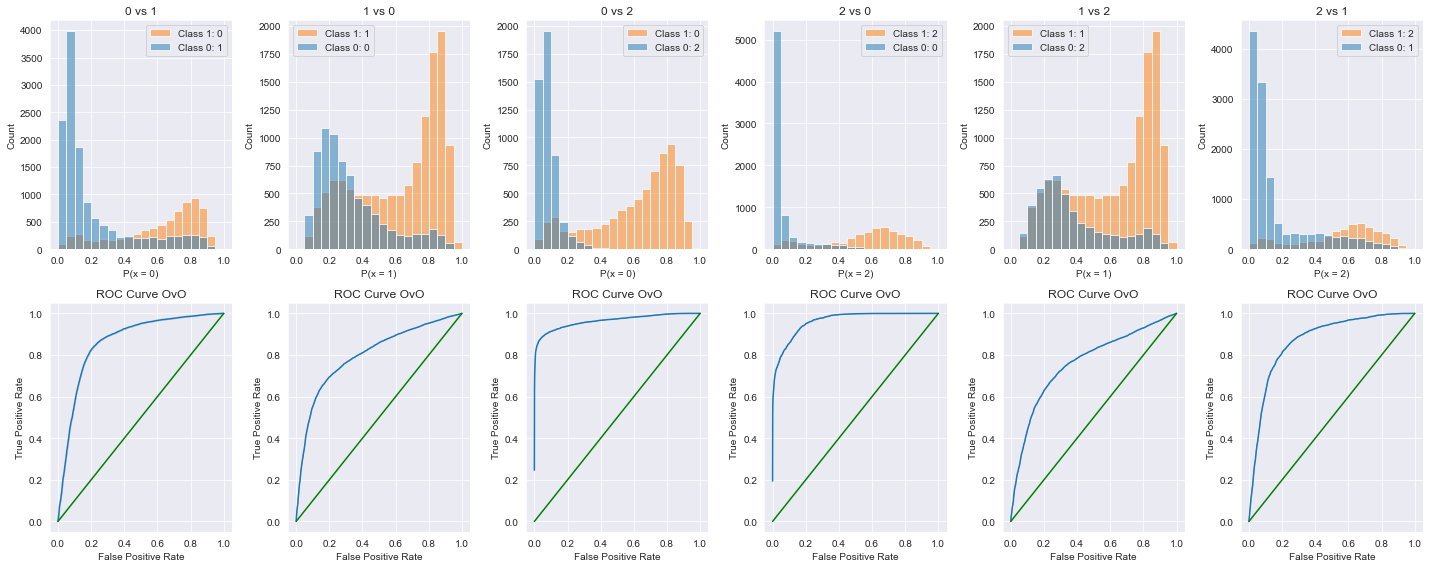

0 vs 1 ROC AUC OvO: 0.8642
1 vs 0 ROC AUC OvO: 0.8005
0 vs 2 ROC AUC OvO: 0.9636
2 vs 0 ROC AUC OvO: 0.9630
1 vs 2 ROC AUC OvO: 0.7608
2 vs 1 ROC AUC OvO: 0.8712
average ROC AUC OvO: 0.8705
sklearn method - average ROC AUC OvO: 0.8705


In [160]:
roc_auc_ovo_plot(x_test, y_test, pipeline)